based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [18]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [19]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
local_dataset_path = f"data/square{IMG_SIZE}_random0.1/"
dataset = load_dataset('imagefolder', data_dir=local_dataset_path)


In [ ]:
dataset = dataset['train']

C:\Users\adamm\AppData\Local\Temp\ipykernel_4140\2340717843.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


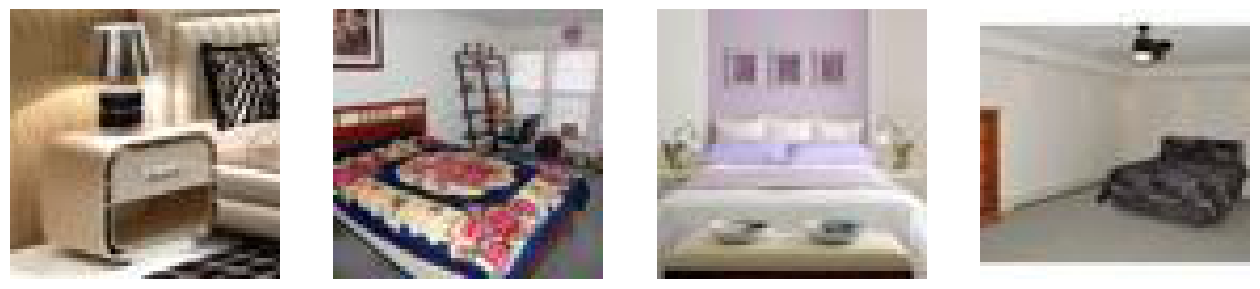

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 64, 64])
Output shape torch.Size([1, 3, 64, 64])


c:\Users\adamm\miniconda3\envs\torchenv\lib\site-packages\diffusers\models\attention_processor.py:1406: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


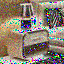

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.2127, device='cuda:0', grad_fn=<MseLossBackward0>)


In [ ]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/50 [00:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
